In [1]:
import numpy as np

import matplotlib.pyplot as plt

from neurodsp.sim import sim_oscillation
from neurodsp.spectral import compute_spectrum

from timescales.sim import sim_ar
from timescales.fit import ARPSD, PSD
from timescales.autoreg import compute_ar_spectrum
from timescales.plts import set_default_rc
set_default_rc()

# 02. PSD Objects

This tutorials explores the use of the PSD objects. There are two PSD models available:

1. `ARPSD`: exact, derived from AR(1)
2. `PSD`: approximate

In [2]:
# Settings
n_seconds = 20
fs = 1000
phi = 0.95
tau = -1 / (np.log(phi) * fs)

# Simulate a signal
np.random.seed(0)
sig = sim_ar(n_seconds, fs, phi)
sig += sim_oscillation(n_seconds, fs, 10) * 5

## Compute Spectra
PSD objects have a `.compute_spectrum` method that may be called from an empty intialization. This method supports neurodsp's `compute_spectrum`, or timescale's `compute_ar_spectrum` function if `ar_order` is passed. External functions that compute spectra may be used, and these arrays may be specificed when initalizing a PSD object. Once the freqs and powers attributes have been defined, the model may be fit.

In [3]:
# Compute spectrum using external function
psd = PSD()
freqs, powers = compute_spectrum(sig, fs)
psd = PSD(freqs, powers)

# Or using class method
psd = PSD()
psd.compute_spectrum(sig, fs)

## Fitting: 1d

`PSD` objects support FOOOF models or any loss function supported by scipy.optimize.least_squares. If a loss function is specified, a single call to scipy's curve fit is used to robustly optimize the aperiodic Lorentzian model. 

When `method` kwarg is in `["fooof", "huber", ... scipy_loss_fn]`:
$$
\begin{align}
    P(f) &= \frac{10^b}{f_k^\chi f^\chi}
\end{align}
$$

When `method='ar'`:

$$
\begin{align}
    P(f) &= \frac{\sigma^{2}}{|1 - \varphi e\strut^{-j 2 \pi \frac{f}{f_s}}|^2}
\end{align}
$$


Alternatively, `ARPSD` objects optimize more complex forms. Below $k$ is the AR order, for exat models this should be one. When AR(1) models do not suffice, the order may be raised, e.g. AR(p=10).

$$
\begin{align}
    P(f) &= \frac{\sigma^{2}}{|1 - \sum\limits_{k=1}^p \varphi_{k} e\strut^{-j 2 \pi \frac{f}{f_s} k}|^{2}}
\end{align}
$$


In [4]:
%%timeit
# Using the fooof package
psd.fit(method='fooof', fooof_init={'peak_threshold': 2.5})

10.8 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%%timeit
# Using fooof aperiodic model + robust regression
psd.fit(method='huber')

2.93 ms ± 47.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%%timeit
# Using AR(1)-PSD model + robust regression
psd.fit(method='ar')

1.79 ms ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


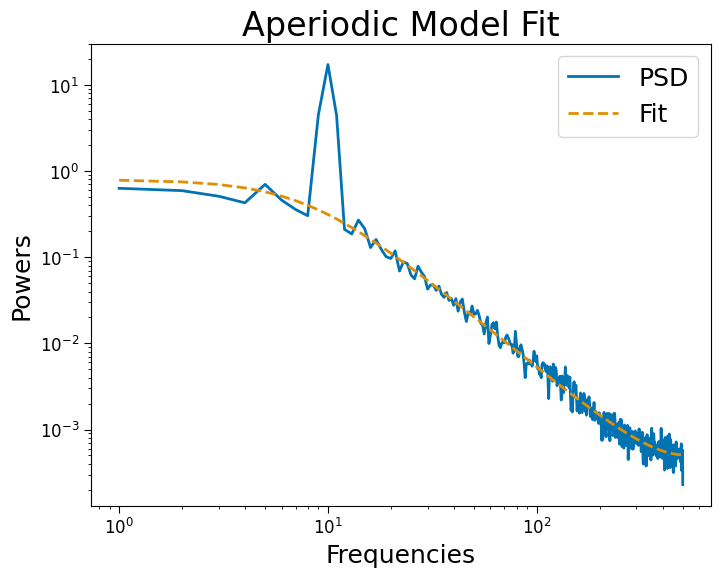

In [7]:
psd.plot()

### Fitting: 2d

2d arrays of signals or powers are supported.

In [8]:
# Simulate signals
fs = 1000
n_seconds = 5

nsigs = 20

sigs = np.zeros((nsigs, int(n_seconds * fs)))
osc = sim_oscillation(n_seconds, fs, 10) * 5
for ind in range(nsigs):
    np.random.seed(ind)
    sigs[ind] = sim_ar(n_seconds, fs, phi)
    sigs[ind] += osc

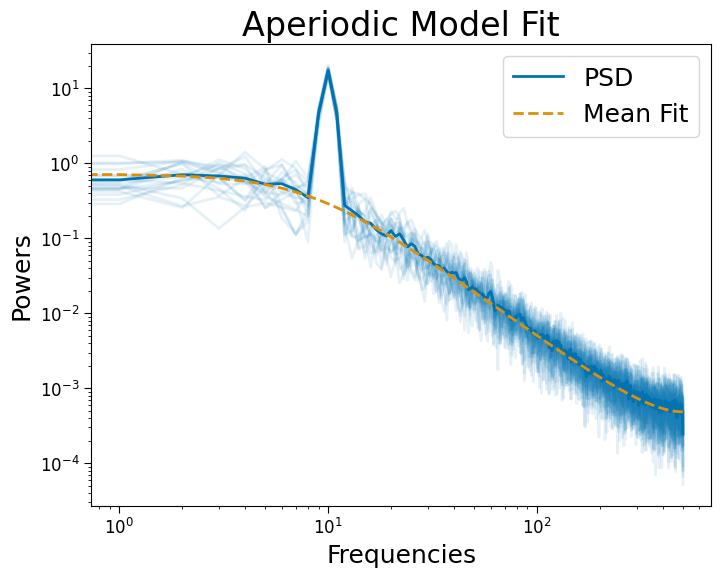

In [9]:
# Fit AR(1)-PSD robustly
psd_ar = PSD()
psd_ar.compute_spectrum(sigs, fs, n_jobs=-1)
psd_ar.fit(method='ar')
psd_ar.plot()

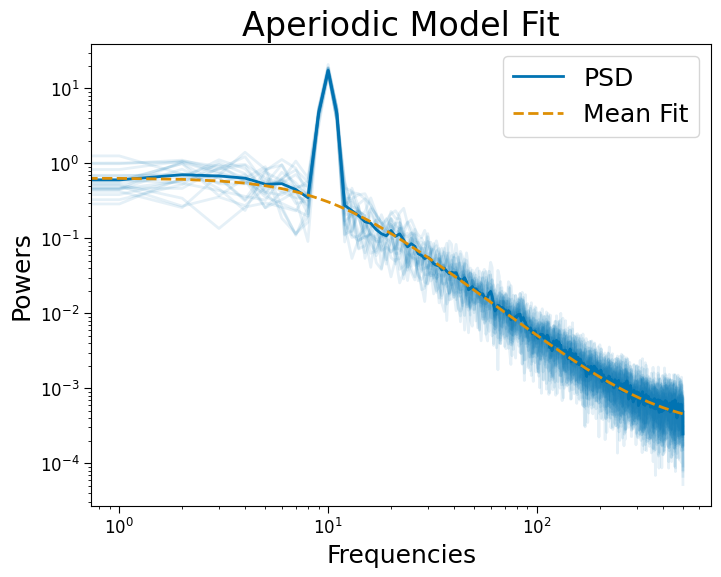

In [10]:
# Fit FOOOF robustly
psd_robust = PSD()
psd_robust.compute_spectrum(sigs, fs, n_jobs=-1)
psd_robust.fit(method='huber')
psd_robust.plot()

## Results

Optimized parameters, labels, and model r-squared values are stored as attributes.

__AR(1)-PSD model:__

In [11]:
psd_ar.param_names

['phi_0', 'offset']

In [12]:
psd_ar.params[:5] # 'phi_0', 'offset'

array([[0.94332773, 0.00179388],
       [0.95363645, 0.00189638],
       [0.95659961, 0.00195419],
       [0.94777176, 0.00182976],
       [0.94924305, 0.00177143]])

In [13]:
psd_ar.tau[:5] # timescales

array([0.01714045, 0.02106471, 0.02253757, 0.01864226, 0.01919739])

In [14]:
psd_ar.rsq[:5] # r-squared

array([0.91003531, 0.91156543, 0.91498511, 0.91001191, 0.91090734])

__FOOOF model with robust regression:__

In [15]:
psd_robust.param_names

['offset', 'knee_freq', 'exp', 'const']

In [16]:
psd_robust.params[:5]

array([[2.06682305e+00, 1.29289216e+01, 2.20366300e+00, 3.30445219e-04],
       [1.97265076e+00, 1.00588562e+01, 2.13388043e+00, 2.87552714e-04],
       [1.73676892e+00, 7.20600236e+00, 2.00725277e+00, 2.45701097e-04],
       [2.03090920e+00, 1.13857241e+01, 2.18318743e+00, 3.41204660e-04],
       [1.60177883e+00, 7.70251629e+00, 1.96763137e+00, 2.27468325e-04]])

In [17]:
psd_robust.rsq[:5]

array([0.91065383, 0.91134276, 0.91532763, 0.91052842, 0.9111365 ])

In [18]:
psd_robust.tau[:5]

array([0.01230999, 0.01582237, 0.02208644, 0.01397846, 0.02066272])